In [1]:
import math
import random
import torch
import numpy as np
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import copy
import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm 
import matplotlib.cm as cm
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import copy
import time

D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#global veriable 
Uniform_low_bound=0
Uniform_up_bound=1
Agent_number_n=5

number_of_groups=2

Normal_loc=0.5
Normal_scale=0.2
Normal_loc1=0.3
Normal_loc2=0.7
Normal_scale1=0.1
Normal_scale2=0.1
Distribution_number=5000
target = "min_max"
#target = "min_sum"

In [3]:
popSize = 100
eliteSize = 10
mutationRate = 0.05
generations = 50

global NeighborhoodRate
NeighborhoodRate = 0.01

In [4]:
class Foo(object):

    def __init__(self, test_item, test_change_item, deadline):
        self.test_item = test_item
        self.test_change_item = test_change_item
        self.deadline = deadline

    def __lt__(self, other):
        return self.test_change_item < other.test_change_item

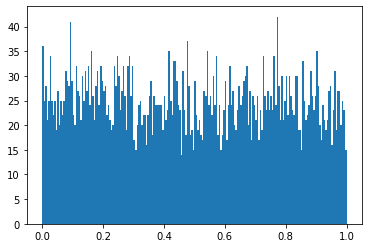

500
4500


In [5]:

seed = 7
np.random.seed(seed)
exec(open('distribution/uniform.py').read())
#exec(open('distribution/beta.py').read())
#exec(open('distribution/twopeak.py').read())
for i in range(len(value_list)):
    for j in range(len(value_list[0])):
        if(value_list[i][j]<=0):
            value_list[i][j]=0
        if(value_list[i][j]>=1):
            value_list[i][j]=1
            
value_list1=np.array(value_list)
for i in range(min(Agent_number_n,1)):
    pa=value_list1[:,i]
    plt.hist(pa,bins=200)
    plt.show()


X_train,  X_test = train_test_split(value_list, test_size=0.9, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
#run_cs()

In [6]:
#Cost Sharing
def run_cs_prue():
    sum_delay=0
    max_delay=0
    test_number=0
    for i in range(len(X_test)):
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test=X_test[i];
        
        for k in range(Agent_number_n,0,-1):
            count=0;
            delay=0;
            for item in test:
                if(item+1e-9>=1.0/k):
                    count+=1;
                else:
                    delay+=1;
            if(count>=k):
                temp_delay=delay;
                if temp_delay != 0 :
                    temp_max_delay = 1
                break;
            if(k<=1):
                #print(test);
                temp_delay=Agent_number_n;
                temp_max_delay=1
        sum_delay+=temp_delay
        max_delay+=temp_max_delay
                
    print("max_delay",max_delay/test_number);
    print("sum_delay",sum_delay/test_number);
    
run_cs_prue()

max_delay 0.6817777777777778
sum_delay 1.4466666666666668


In [7]:
def cost_sharing_with_deadline(test,t_c,target):
    temp_max_delay_list=[0 for i in range(len(test))]
    temp_sum_delay=0
    result=False
    for k in range(len(test),0,-1):
        count=0;
        delay=0;
        for ii in range(len(test)):
            item= test[ii]
            if(item+1e-9>=target/k):
                count+=1;
            else:
                delay+=t_c[ii];
                temp_max_delay_list[ii]=t_c[ii]
            
        if(count>=k):
            temp_sum_delay+=delay;
            result=True
            break;
        if(k<=1):
            #print(test,number_n);
            temp_max_delay_list=t_c
            temp_sum_delay=sum(t_c);
            result=False
            
    return temp_max_delay_list,temp_sum_delay,result

def cost_sharing_with_deadline_free(n,_i,numbers_of_people_will_pay,started_k):
    
    for k in range(started_k,0,-1):
        if(n-_i<=k):
            x=k-1
        else:
            x=k
        #print(n,_i,x,numbers_of_people_will_pay[x],k)
        if(numbers_of_people_will_pay[x]>=k):
            return True,k
    return False,0

#Cost Sharing
def run_cs(deadline_list):
    sum_delay=0
    max_delay=0
    test_number=0
    seconds_start=time.time()
    for i in range(len(X_train)):
#        if(i%1000==0):
#            seconds=time.time()
#            print("times: ",seconds-seconds_start)
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test = copy.deepcopy(X_train[i])
        #test_change = copy.deepcopy(X_test[i]);
        test_change_temp = []
        Foo_list = []
        
#         seconds=time.time()
#         print("times: ",seconds-seconds_start)
        
        
        for j in range(len(test)):
            test_change_temp.append(test[j] * deadline_list[j])
            Foo_list.append(Foo(test[j],test_change_temp[j],deadline_list[j]))
            
        Foo_list.sort(reverse=False)
        

        for j in range(len(test)):
            test[j]=Foo_list[j].test_item
            test_change_temp[j]=Foo_list[j].test_change_item
            deadline_list[j]=Foo_list[j].deadline

        test_change = copy.deepcopy(test_change_temp);
        
        numbers_of_people_will_pay = [-10 for ii in range(len(test_change)+2)]#pay 1/k
        
#         seconds=time.time()
#         print("times: ",seconds-seconds_start)
        
        k = 1
        started=len(test_change)-1
        end_k=-10
        for j in range(len(test_change)):
            if(k<=len(test_change)):
                for people_id in range(started,-1,-1):
                    if(test_change[people_id]+1e-9>=1.0/k):
                        started=people_id
                        numbers_of_people_will_pay[k]=len(test_change)-people_id
                        end_k=len(test_change)-people_id
                    else:
                        k+=1
                        break;
                    
        for j in range(k,len(test_change)+1):
            numbers_of_people_will_pay[j]=end_k
            
        deadlist_new=copy.deepcopy(deadline_list)
        
        temp_max_delay_list,temp_sum_delay,judge_i =  cost_sharing_with_deadline(test_change,
                        deadlist_new,1.0)
        
        judge_i= True
        started_k = len(test)
        for _i in range(len(test_change)):
            if judge_i:
                judge_i,started_k =  cost_sharing_with_deadline_free(len(test_change),
                    _i,numbers_of_people_will_pay,started_k)
                
                
            started_k+=1
            if(judge_i==False):
                temp_sum_delay += (1.0-deadline_list[_i])
                temp_max_delay_list[_i] += (1.0-deadline_list[_i])
        
        max_delay+=max(temp_max_delay_list)
        
        sum_delay+=temp_sum_delay
        
                
    #print("max_delay",max_delay/test_number);
    if(target == "min_sum"):
        return sum_delay/test_number
    if(target == "min_max"):
        return max_delay/test_number
    #print("deadline:",deadline," sum_delay: ",sum_delay/test_number);
    


1.Create a fitness function

In [8]:
class Deadline_list:
    def __init__(self, deadline):
        self.deadline = deadline
        self.delay = 0
        self.fitness = 0.0
    
    def Delay(self):
        if self.fitness == 0:
            self.delay = run_cs(self.deadline)
            self.fitness = self.delay
            
            #print(self.deadline,self.fitness)
        return self.delay,self.deadline


## Create our initial population

Initial generator

Create first "population" (list of routes)

In [9]:
pool_items=[]
#for i in range(1,Agent_number_n+1):
#    pool_items.append(1.0/i)
for i in range(0,11):
    pool_items.append(float(i)/10) 
for i in range(1,10001):
    pool_items.append(np.random.random())
print(pool_items)
def produce_initial_Deadline_list(Agent_number_n):
    initial_list=[]
    for j in range(Agent_number_n):
        initial_list.append(pool_items[np.random.randint(0,len(pool_items)-1)])
    #print(len(initial_list))
    return Deadline_list(np.array(initial_list))

def initialPopulation(popSize, Agent_number_n):
    population = []
    for i in range(0, 10):
        population.append(Deadline_list(np.array([float(i+1)/10 for j in range(Agent_number_n)])))
    for i in range(10, popSize):
        population.append(produce_initial_Deadline_list(Agent_number_n))
    return population


[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.5286426607762248, 0.6996481271078544, 0.32498883963528136, 0.6330167720767164, 0.18680301197704663, 0.8734766167986474, 0.7795099921482344, 0.6872787956595526, 0.1610506593374469, 0.3441420368947943, 0.07548632233642949, 0.029996057396265763, 0.6534444010025134, 0.3464493309060461, 0.05887499575509936, 0.849608814570592, 0.7562810019535748, 0.28956405418803655, 0.8429633050770283, 0.173872389236444, 0.7342043956109809, 0.07952313844931036, 0.26985530203546493, 0.311741769093146, 0.6106790958341206, 0.7780349200568822, 0.396881692836496, 0.24323341455114333, 0.15459240353995185, 0.9821667150618134, 0.0414227331930207, 0.42788516780118147, 0.8216435532381797, 0.6768839333549327, 0.26144377305431343, 0.6165752674253697, 0.014744928150395076, 0.9915223805619758, 0.9180829165663087, 0.07745023389869377, 0.5014229288833713, 0.3392427389094895, 0.8633139426602069, 0.8077989342719625, 0.11652912593955655, 0.385975558706498, 0.8903858404

## Create the genetic algorithm

Rank individuals

In [10]:
def rankDeadlines(population):
    fitnessResults = []
    for i in range(0,len(population)):
        temp = population[i].Delay()
        fitnessResults.append([i, temp[0], temp[1]])
    fitnessResults = np.array(fitnessResults)
    
    return sorted(fitnessResults, key = operator.itemgetter(1))

Create a selection function that will be used to make the list of parent routes

In [11]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness","Deadline"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [12]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

In [13]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    #childP2 = [item for item in parent2 if item not in childP1]
    
    for i in range(0, startGene):
        child.append(parent2[i])
    child = child+childP1
    for i in range(endGene, len(parent2)):
        child.append(parent2[i])
    #child = childP1 + childP2
    return child

Create function to run crossover over full mating pool

In [14]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i].deadline, pool[len(matingpool)-i-1].deadline)
        children.append(Deadline_list(child))
    return children

Create function to mutate a single route

In [15]:
def mutate(individual, mutationRate):
    global NeighborhoodRate 
    
    individual_deadline = individual.deadline 
    
    for swapped in range(len(individual_deadline)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual_deadline))
            
            deadline_1 = copy.deepcopy(individual_deadline[swapped])
            deadline_2 = copy.deepcopy(individual_deadline[swapWith])
            
            individual_deadline[swapped]  = deadline_2
            individual_deadline[swapWith] = deadline_1
            
            individual.fitness=0
    
    for nerboorhood in range(len(individual_deadline)):
        
        if(random.random() < NeighborhoodRate):
            if(random.random()>=0.5):
                individual_deadline[nerboorhood]+= 0.01
                if(individual_deadline[nerboorhood]>=1):
                    individual_deadline[nerboorhood]=1
            else:
                individual_deadline[nerboorhood]-= 0.01
                if(individual_deadline[nerboorhood]<=0):
                    individual_deadline[nerboorhood]=0
            individual.fitness=0
                
    individual.deadline = individual_deadline
    return individual

Create function to run mutation over entire population

In [16]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [17]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    print(len(currentGen))
    #oldGen = copy.deepcopy(currentGen)
    popRanked = rankDeadlines(currentGen)

    selectionResults = selection(popRanked, eliteSize)
#     for i in range(0, len(popRanked)):
#         print(popRanked[i][0],end=" ")
#    print("len:",len(selectionResults),selectionResults)
    matingpool = matingPool(currentGen, selectionResults)
    

#     for i in range(len(currentGen)):
#         print(currentGen[i].deadline,currentGen[i].fitness)
        
#     for i in range(len(matingpool)):
#         print(matingpool[i].deadline,matingpool[i].fitness)
        
    children = breedPopulation(matingpool, eliteSize)

    
    nextGeneration = mutatePopulation(children, mutationRate)
    
#     print("1: ",popRanked[0])
#     print("2: ",selectionResults[0])
#     print("3: ",matingpool[0])
#     print("4: ",children[0])
#     print("5: ",nextGeneration[0])
    for i in range(len(nextGeneration), popSize):
        nextGeneration.append(produce_initial_Deadline_list(Agent_number_n))
                
#     for i in range(len(oldGen)):
#         if(oldGen[i].Delay()[0]<nextGeneration[i].Delay()[0]):
#             nextGeneration[i]=oldGen[i]
    return nextGeneration

In [18]:

pop = np.array(initialPopulation(popSize, Agent_number_n))

# for i in range(len(pop)):
#     print(pop[i].deadline)

In [19]:
temp_a = np.array(rankDeadlines(pop))
#print(temp_a )

Final step: create the genetic algorithm

In [20]:
def geneticAlgorithm(pop, popSize, eliteSize, mutationRate, generations):

    print("Initial Delay: " + str(rankDeadlines(pop)[0][1]))
    bestdeadlineIndex = rankDeadlines(pop)[0][0]
    bestdeadline = pop[bestdeadlineIndex]
    print("deadline:")
    for j in range(len (bestdeadline.deadline)):
        print('%.4f' % bestdeadline.deadline[j], end=" ")
    print()
    print()
    progress = []
    progress.append(rankDeadlines(pop)[0][1])
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        print("Generation " , i , " : " + str(rankDeadlines(pop)[0][1]))
        progress.append(rankDeadlines(pop)[0][1])
        bestdeadlineIndex = rankDeadlines(pop)[0][0]
        bestdeadline = pop[bestdeadlineIndex]
        print("deadline:")
        for j in range(len (bestdeadline.deadline)):
            print('%.4f' % bestdeadline.deadline[j], end=" ")
        print()
        print()
        

    
    print("Final Delay: " + str(rankDeadlines(pop)[0][1]))
    bestdeadlineIndex = rankDeadlines(pop)[0][0]
    bestdeadline = pop[bestdeadlineIndex]
    
    #print(progress)
    plt.plot(progress)
    plt.ylabel('Delay')
    plt.xlabel('Generation')
    plt.show()
    return bestdeadline

## Running the genetic algorithm

Create list of cities

Run the genetic algorithm

Initial Delay: 0.6592000000000032
deadline:
0.8000 0.8000 0.8000 0.8000 0.8000 

100
Generation  0  : 0.6592000000000032
deadline:
0.8000 0.8000 0.8000 0.8000 0.8000 

100
Generation  1  : 0.6601200000000024
deadline:
0.8000 0.8000 0.8000 0.8000 0.8100 

100
Generation  2  : 0.6601200000000024
deadline:
0.8000 0.8000 0.8000 0.8000 0.8100 

100
Generation  3  : 0.6601200000000024
deadline:
0.8000 0.8000 0.8000 0.8000 0.8100 

100
Generation  4  : 0.6601200000000024
deadline:
0.8000 0.8000 0.8000 0.8000 0.8100 

100
Generation  5  : 0.6605800000000024
deadline:
0.8000 0.8000 0.8000 0.8000 0.8100 

100
Generation  6  : 0.6588400000000024
deadline:
0.8000 0.8000 0.8000 0.8000 0.8100 

100
Generation  7  : 0.6588400000000024
deadline:
0.8000 0.8000 0.8000 0.8000 0.8100 

100
Generation  8  : 0.6588400000000024
deadline:
0.8000 0.8000 0.8000 0.8000 0.8100 

100
Generation  9  : 0.6592000000000032
deadline:
0.8000 0.8000 0.8000 0.8000 0.8000 

100
Generation  10  : 0.6592000000000032
deadline

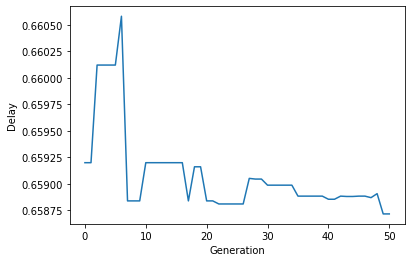

In [21]:
result = geneticAlgorithm(pop, popSize, eliteSize, mutationRate, generations)

In [22]:
print("training delay")
print(result.delay)
print("training deadline:")
for i in range(len (result.deadline)):
    print(result.deadline[i])

training delay
0.6587172934629232
training deadline:
0.7983924712113626
0.8
0.7983924712113626
0.8
0.8155681660755907


In [23]:
print(run_cs(result.deadline))

#Cost Sharing
def run_cs_test(deadline_list):
    sum_delay=0
    max_delay=0
    test_number=0
    seconds_start=time.time()
    for i in range(len(X_test)):
#        if(i%1000==0):
#            seconds=time.time()
#            print("times: ",seconds-seconds_start)
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test = copy.deepcopy(X_test[i])
        #test_change = copy.deepcopy(X_test[i]);
        test_change_temp = []
        Foo_list = []
        
#         seconds=time.time()
#         print("times: ",seconds-seconds_start)
        
        
        for j in range(len(test)):
            test_change_temp.append(test[j] * deadline_list[j])
            Foo_list.append(Foo(test[j],test_change_temp[j],deadline_list[j]))
            
        Foo_list.sort(reverse=False)
        

        for j in range(len(test)):
            test[j]=Foo_list[j].test_item
            test_change_temp[j]=Foo_list[j].test_change_item
            deadline_list[j]=Foo_list[j].deadline

        test_change = copy.deepcopy(test_change_temp);
        
        numbers_of_people_will_pay = [-10 for ii in range(len(test_change)+2)]#pay 1/k
        
#         seconds=time.time()
#         print("times: ",seconds-seconds_start)
        
        k = 1
        started=len(test_change)-1
        end_k=-10
        for j in range(len(test_change)):
            if(k<=len(test_change)):
                for people_id in range(started,-1,-1):
                    if(test_change[people_id]+1e-9>=1.0/k):
                        started=people_id
                        numbers_of_people_will_pay[k]=len(test_change)-people_id
                        end_k=len(test_change)-people_id
                    else:
                        k+=1
                        break;
                    
        for j in range(k,len(test_change)+1):
            numbers_of_people_will_pay[j]=end_k
            
        deadlist_new=copy.deepcopy(deadline_list)
        
        temp_max_delay_list,temp_sum_delay,judge_i =  cost_sharing_with_deadline(test_change,
                        deadlist_new,1.0)
        
        judge_i= True
        started_k = len(test)
        for _i in range(len(test_change)):
            if judge_i:
                judge_i,started_k =  cost_sharing_with_deadline_free(len(test_change),
                    _i,numbers_of_people_will_pay,started_k)
                
                
            started_k+=1
            if(judge_i==False):
                temp_sum_delay += (1.0-deadline_list[_i])
                temp_max_delay_list[_i] += (1.0-deadline_list[_i])
        
        max_delay+=max(temp_max_delay_list)
        
        sum_delay+=temp_sum_delay
        
                
    #print("max_delay",max_delay/test_number);
                

    return max_delay/test_number,sum_delay/test_number

    
print("test:",run_cs_test(result.deadline))

0.6604675592521463
test: (0.6650014116722703, 2.008254468535075)


In [24]:
print("pure CS")
run_cs_prue()

pure CS
max_delay 0.6817777777777778
sum_delay 1.4466666666666668


In [25]:
print("0.5 for test:",run_cs_test([0.5 for i in range(Agent_number_n)]))
print("0.5 for train:",run_cs([0.5 for i in range(Agent_number_n)]))
print("GA test:",run_cs_test(result.deadline))


0.5 for test: (0.8378888888888889, 4.100777777777778)
0.5 for train: 0.828
GA test: (0.664997952079809, 2.008203462134328)


In [26]:
list_1=[]
list_2=[]
list_3=[]
for i in range(1,501):
    x=float(i)/500
    xx=[x for i in range(Agent_number_n)]
    #print(xx)
    res1,res2=run_cs_test(xx)
    list_1.append(res1)
    list_2.append(res2)
    list_3.append(x)
print("max_delay:",min(list_1),"deadline:",list_3[list_1.index(min(list_1))])
print("sum_dealy:",min(list_2),"deadline:",list_3[list_2.index(min(list_2))])

max_delay: 0.6601093333333654 deadline: 0.842
sum_dealy: 1.4466666666666668 deadline: 1.0


In [27]:
print("target:",target)
print("sum_delay")
print("GA:",run_cs_test(result.deadline)[1],"one_deadline:",min(list_2))
print("{:.4%}".format(run_cs_test(result.deadline)[1]/min(list_2)))

target: min_max
sum_delay
GA: 2.008203462134328 one_deadline: 1.4466666666666668
138.8159%


In [28]:
print("max_delay")
print(run_cs_test(result.deadline)[0],"one_deadline:",min(list_1))
print("{:.4%}".format(run_cs_test(result.deadline)[0]/min(list_1)))

max_delay
0.664997952079809 one_deadline: 0.6601093333333654
100.7406%


In [29]:
def cost_sharing_with_deadline_old(test,t_c,target):
    temp_max_delay_list=[0 for i in range(len(test))]
    temp_sum_delay=0
    result=False
    for k in range(len(test),0,-1):
        count=0;
        delay=0;
        for ii in range(len(test)):
            item= test[ii]
            if(item+1e-9>=target/k):
                count+=1;
            else:
                delay+=t_c[ii];
                temp_max_delay_list[ii]=t_c[ii]
            
        if(count>=k):
            temp_sum_delay+=delay;
            result=True
            break;
        if(k<=1):
            #print(test,number_n);
            temp_max_delay_list=t_c
            temp_sum_delay=sum(t_c);
            result=False
            
    return temp_max_delay_list,temp_sum_delay,result



#Cost Sharing
def run_cs_old(deadline_list):
    sum_delay=0
    max_delay=0
    test_number=0
    for i in range(len(X_test)):
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test = copy.deepcopy(X_test[i])
        #test_change = copy.deepcopy(X_test[i]);
        test_change = []

        for j in range(len(test)):
            test_change.append(test[j] * deadline_list[j])
            
        
        temp_max_delay_list,temp_sum_delay,judge1 = cost_sharing_with_deadline_old(test_change,
                        copy.deepcopy(deadline_list),1.0)
        for j in range(len(test_change)):
            test_i = copy.deepcopy(test_change);
            test_i = np.delete(test_i, j)
            
            deadline_i = copy.deepcopy(deadline_list);
            deadline_i = np.delete(deadline_i, j)
            
            temp_max_delay_i_list,temp_sum_delay_i,judge_i = cost_sharing_with_deadline_old(test_i,
                        deadline_i,1.0)
            
            if(judge_i==False):
                temp_sum_delay += (1.0-deadline_list[j])
                temp_max_delay_list[j] += (1.0-deadline_list[j])
                
            
        
        max_delay+=max(temp_max_delay_list)
        
        sum_delay+=temp_sum_delay
        
    print("deadline: ",deadline_list)
    print("sum_delay: ",sum_delay/test_number)
    print("max_delay: ",max_delay/test_number)
    print()
    return max_delay/test_number,sum_delay/test_number
    
print(run_cs_old(result.deadline))


deadline:  [0.7983924712113626, 0.8, 0.7983924712113626, 0.8155681660755907, 0.8]
sum_delay:  2.000579343918261
max_delay:  0.6638142498622082

(0.6638142498622082, 2.000579343918261)
